# Mapping and clustering analysis for NI tests 

### Requirements and dependencies

In [1]:
import sys
import os
import pandas as pd
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(override=True)
from MLforMultiphaseMaterials.MicroMechanicalMapping.AnalyzePlot_mech import analyze_data_to_mi, analyze_stat_to_mi, estimate_microstructure_from_kamm
from MLforMultiphaseMaterials.Tools.ImportData import read_data_xls, read_json_info
from MLforMultiphaseMaterials.Tools.ExportData import export_data_to_MI
from MIdata.MI_createData import updateLinks_MI
from MIdata.MI_connect import getDB_MI

#### Database and specimen informations

In [2]:
# Database information
username = os.getenv('USERNAME')
password = os.getenv('PASSWORD')
serverName = "https://nanomecommons.grantami.com/mi_servicelayer"
projectName = "Materials Project for NanoMECommons"
db_Key = "MI_Blank_v2021" 

In [11]:
# ------------------------------------------
# Specimen of reference information (Ni-SiC)
# -----------------------------------------
sampleNames = ['Ni_SiC']
file_paths = [Path(f'../Data/Hybrids/Reference_Materials/Inputs/Ni_SiC/MTS_example1_25x25.xls_interp_81x81.xls')]
sheet_name = 'Sample'

### Adding data and creating records to the MI database in TEST TABLE

In [12]:
tableName = "Indentation test data"
folderName = ["Python Demo"]

phaseNum = 1 # Used to define color of the record 1 for red and 2 for blue

listAttributes = ['Test Date', 'Operator', 'Partner', 
                  'Grade name', 'Specimen code', 'Material Family',
                  'Test equipment ID', 'Temperature Test', 'Grid indentation pattern', 
                  'Number of points (X axis)','Number of points (Y axis)', 'Space between points (X axis)','Space between points (Y axis)',
                  'Mechanical properties matrix']
listAttributeswithMeta = ['Mechanical properties matrix', 'Mechanical properties matrix', 'Mechanical properties matrix', 'Mechanical properties matrix']
listAttributesMeta = ["Young's modulus", "Hardness", "Creep", "H over E"]

dataType = 'NI'


## Kernel Average Mechanical Mismatch Version

KAM is calculated by comparing the **property of interest** (e.g., modulus, hardness, or their product) between a central pixel and its neighboring pixels.

### Given:

- \( P_{i,j} \): the value of the property at pixel location \( (i,j) \)
- \( P_{k,l} \): the value of the property at a neighboring pixel \( (k,l) \in \mathcal{N}(i,j) \)
- \( \Delta(P_{i,j}, P_{k,l}) = | P_{i,j} - P_{k,l} | \): the mechanical mismatch
- \( |\mathcal{N}(i,j)| \): the number of neighboring pixels

### Mechanical Mismatch:

$$
\Delta(P_{i,j}, P_{k,l}) = | P_{i,j} - P_{k,l} |
$$


### Kernel Average Misorientation (KAM):

#### 1. For Elastic modulus (E):

$$
\text{KAEM}_{i,j} = \frac{1}{|\mathcal{N}(i,j)|} \sum_{(k,l) \in \mathcal{N}(i,j)} \Delta(E_{i,j}, E_{k,l})
$$

#### 2. For Hardness (H):

$$
\text{KAPH}_{i,j} = \frac{1}{|\mathcal{N}(i,j)|} \sum_{(k,l) \in \mathcal{N}(i,j)} \Delta(H_{i,j}, H_{k,l})
$$

#### 3. For the product of Modulus and Hardness (M = E × H):

$$
\text{KAMM}_{i,j} = \frac{1}{|\mathcal{N}(i,j)|} \sum_{(k,l) \in \mathcal{N}(i,j)} \Delta(M_{i,j}, M_{k,l}), \quad \text{with } M = |E \times H|
$$

### Notes:

- The neighborhood \( \mathcal{N}(i,j) \) typically includes 4 or 8-connected pixels.
- This formulation highlights local variations in mechanical properties across a mapped surface.


Connection test failed: Unauthorized.


Connected to the server with username and password
Database GUID: 76be43d5-3fd4-417c-887f-78ed3b76669b
Table GUID: c5a70777-053f-4450-921e-b5247843dfcf
JSON data is valid and coherent.
Data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\example_MTS_example1_25x25.xls_interp_81x81.csv
new_data columns before compute_kam: ['X position', 'Y position', 'Z position', "Young's modulus value", 'Hardness value', 'Creep', 'H over E']
Raw data columns: ['X position', 'Y position', 'Z position', "Young's modulus value", 'Hardness value', 'Creep', 'H over E']
Columns after lowercasing: ['x position', 'y position', 'z position', "young's modulus value", 'hardness value', 'creep', 'h over e']
KAMM results saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\KAMM_results.csv
KAEM results saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids

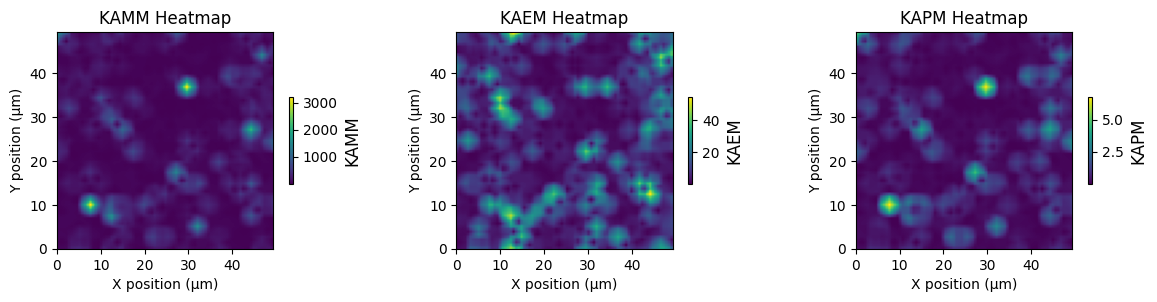

All filtered data saved to: C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\All_data.csv


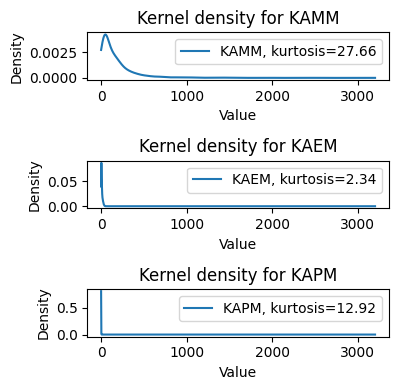

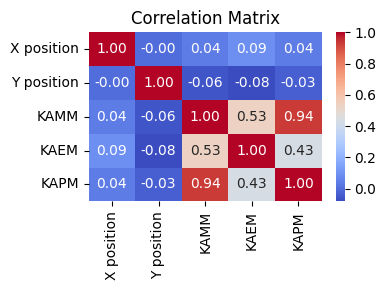

Heatmap dimensions: (81, 81)


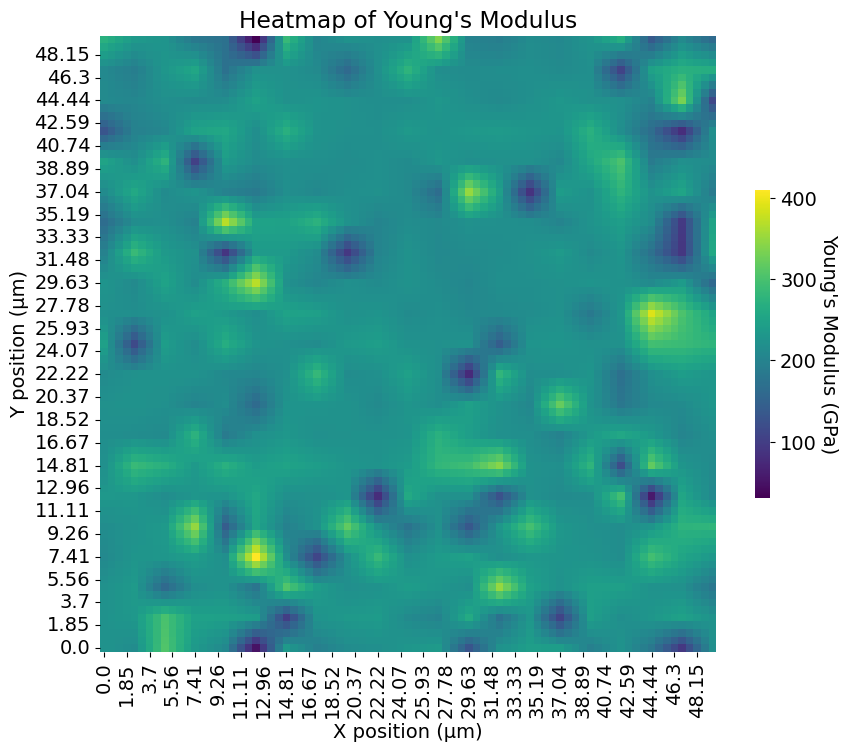

Heatmap dimensions: (81, 81)


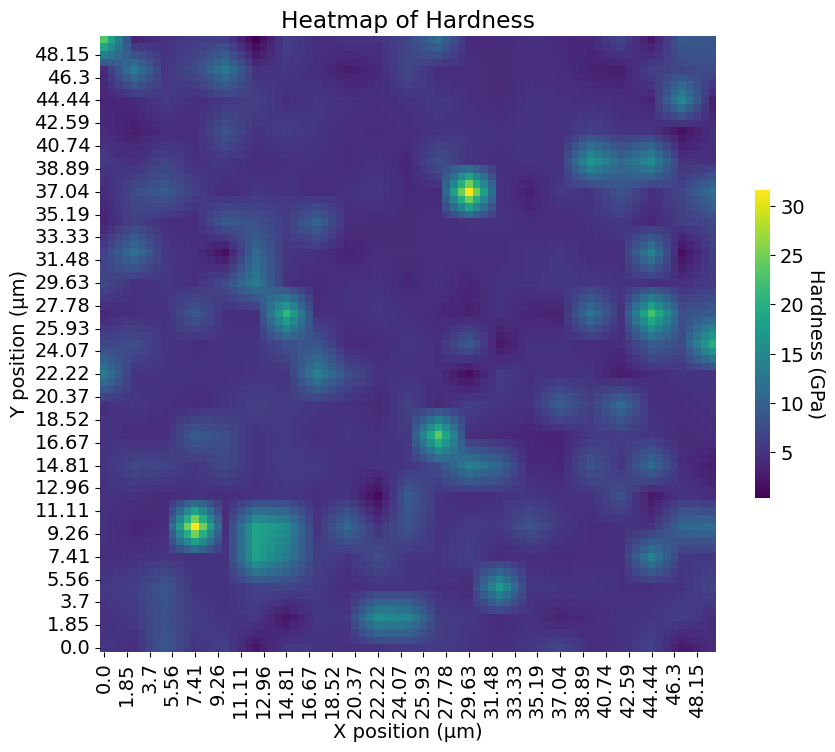

Heatmap dimensions: (81, 81)


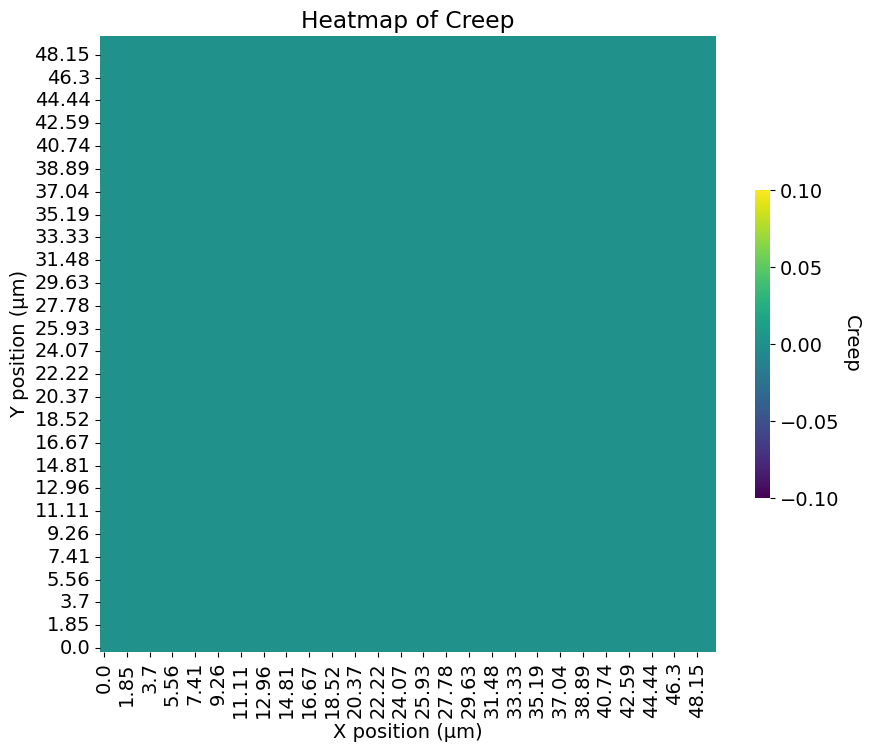

Heatmap dimensions: (81, 81)


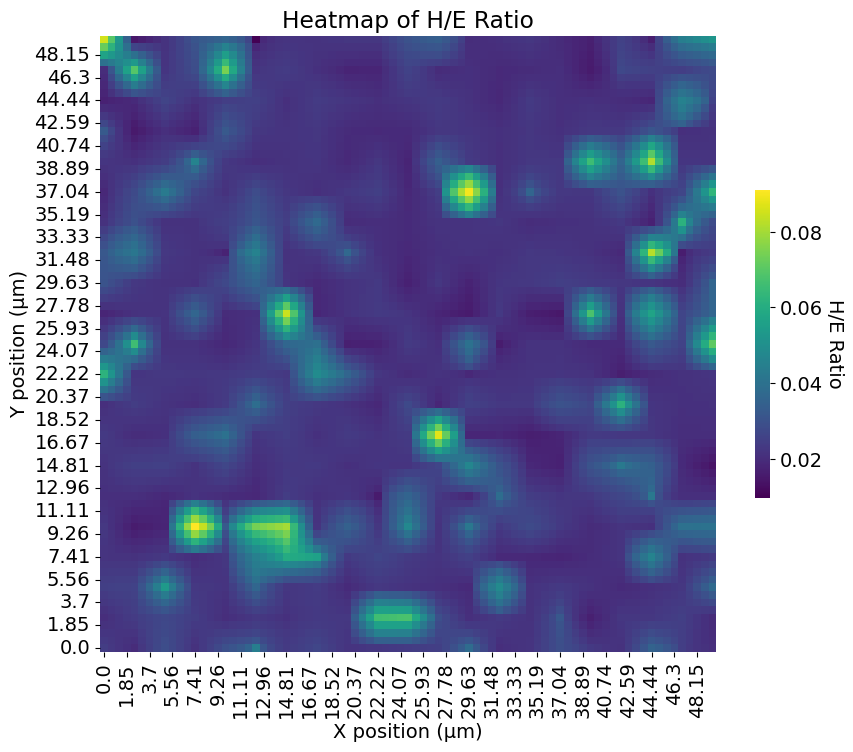

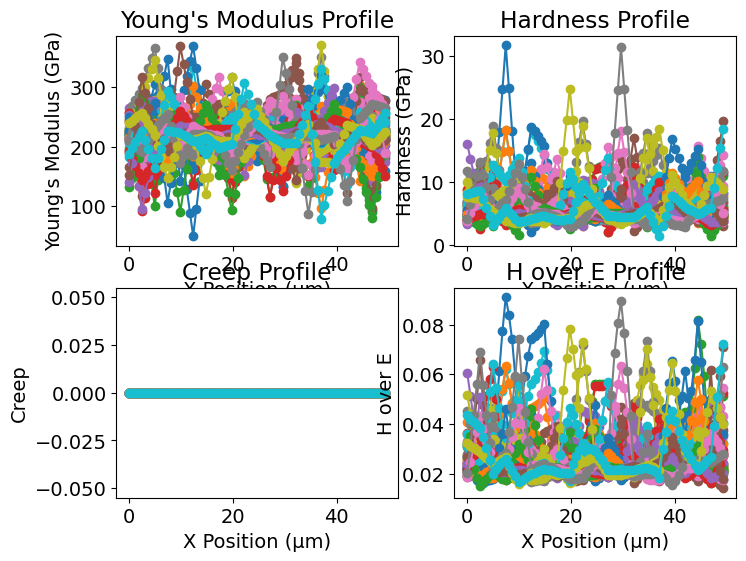

In [5]:
# -------------------------------------------------------------
#Display heatmap of properties, correlation matrix, profiles...
# -------------------------------------------------------------
for sampleName, file_path in zip(sampleNames, file_paths):
    output_folder = Path(f'{file_path.parents[2].resolve()}/Outputs_MechanicalData/{sampleName}')
    json_folder = Path(f'{file_path.parents[2]}/Inputs/{sampleName}')
    mi_import, db_import, table_import = getDB_MI(serverName, username, password, db_Key, tableName)

    #Import data
    data = read_data_xls(file_path, sheet_name)
    json_path, json_data = read_json_info(file_path, json_folder, '_NI_info')
    
    #Analysis and export data : 
    inputs, inputsMeta, recordName = analyze_data_to_mi(file_path, data, json_data, json_path, 
                                                        listAttributes, listAttributesMeta, output_folder, sampleName, dataType)
    
# ---------------------------------
# Estimate microstructure from KAMM
# ---------------------------------
    kamm_csv_path = output_folder / "KAEM_results.csv"  # Assuming KAMM results are saved here
    
    material_name = sampleName  # Use the sample name as the material name
    phase_map = estimate_microstructure_from_kamm(kamm_csv_path, output_folder, material_name)

#------------------
# Export dat to MI
#------------------
    record_ini = {}
    # Export data to MI: 
    record = export_data_to_MI(mi_import, projectName, table_import, folderName, recordName, phaseNum, 
                      listAttributes, listAttributeswithMeta, inputs, inputsMeta)
    record_ini[sampleName] = record

### Adding data and creating records to the MI database in STATISTICAL TABLE

In [6]:
table_name_ini = tableName #For links creation in MI
table_name = 'Indentation statistical data'
folder_name = 'Python Demo'
phaseNum = 1 # Used to define color of the record 1 for red and 2 for blue

listAttributes = ['Analysis Date', 'Analyst', 'Partner', 
                  'Grade name', 'Specimen code', 'Material Family',
                  'Reduced elastic modulus (mean)', 'Hardness (mean)', 'Hardness over Reduced Elastic Modulus', 'Creep (mean)',
                  #'Average Load', 'Average Reduced Elastic Modulus', 'Average Hardness', 'Average Creep',
                  'Correlation matrix', 'All plots matrix',
                  'ML method used to analyze NI data',
                  'Elastic modulus', 'Y coordinate',
                  'Picture']
listAttributeswithMeta = ['Reduced elastic modulus (mean)', 'Reduced elastic modulus (mean)', 'Reduced elastic modulus (mean)', 'Reduced elastic modulus (mean)',
                          'Hardness (mean)', 'Hardness (mean)', 'Hardness (mean)', 'Hardness (mean)',
                          'Hardness over Reduced Elastic Modulus', 'Hardness over Reduced Elastic Modulus', 'Hardness over Reduced Elastic Modulus',
                          'Creep (mean)', 'Creep (mean)', 'Creep (mean)',
                          'ML method used to analyze NI data', 'ML method used to analyze NI data'
                          ]
listAttributesMeta = ['Maximum', 'Minimum', 'Standard deviation', 'Probability distribution - Reduced elastic modulus',
                      'Maximum', 'Minimum', 'Standard deviation', 'Probability distribution - Hardness',
                      'Maximum', 'Minimum', 'Standard deviation',
                      'Maximum', 'Minimum', 'Standard deviation',
                      'Optimal number of phase(s) (elbow, BIC...)',
                      'Silhouete score'
                      ]

In [7]:
for sampleName, file_path in zip(sampleNames, file_paths):
    folderName = []
    folderName = [folder_name, f'{sampleName}']
    output_folder = Path(f'{file_path.parents[2].resolve()}/Outputs_MechanicalData/{sampleName}')
    json_folder = Path(f'{file_path.parents[2]}/Inputs/{sampleName}')
    mi_import, db_import, table_import = getDB_MI(serverName, username, password, db_Key, table_name)
    #Import data : 
    data = read_data_xls(file_path, sheet_name)
    json_path, json_data = read_json_info(file_path, json_folder, '_NI_info')
    MLmethods = json_data['Clustering and Mapping'].get('ML method used to analyze NI data', "")
    opt_clusters_method = json_data['Clustering and Mapping'].get('Method used to determine n_cluster')
    image_paths = pd.DataFrame()

Connection test failed: Unauthorized.


Connected to the server with username and password
Database GUID: 76be43d5-3fd4-417c-887f-78ed3b76669b
Table GUID: 8c5e1bce-e755-4c5b-9777-1d3793b3b10a
JSON data is valid and coherent.


Modulus column after handling zeros and NaN: 0    224.600
1    222.075
2    219.550
3    217.025
4    214.500
Name: modulus, dtype: float64
Data columns before clustering: ['index', 'x position', 'y position', 'modulus', 'hardness', 'h over e', 'creep']


c:\github\ICME-OoCTO\MLforMultiphaseMaterials\MicroMechanicalMapping\AnalyzePlot_mech.py:258: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['modulus'] = data['modulus'].fillna(1e-6)       # Replace NaN with a small positive value


Data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\example_MTS_example1_25x25.xls_interp_81x81.csv
New data columns in analyze_stat_to_mi: ['X position', 'Y position', 'Z position', "Young's modulus value", 'Hardness value', 'Creep', 'H over E']
Data columns after dropping 'markers' and 'Index': ['index', 'x_position', 'y_position', 'modulus', 'hardness', 'h_over_e', 'creep']
Index(['index', 'x_position', 'y_position', 'modulus', 'hardness', 'h_over_e',
       'creep'],
      dtype='object')


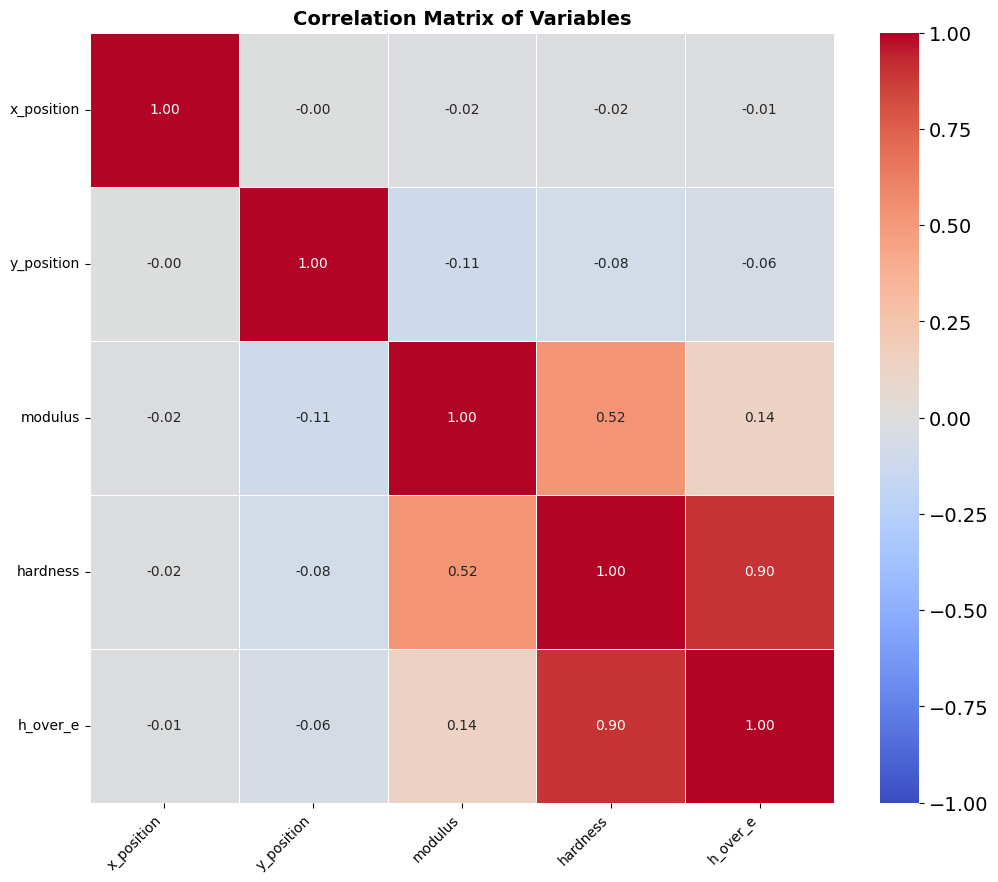

Correlation max is: x_position
Found 1 peaks at indices: [37]
 Peak 1: x=0.022, y=36.65810


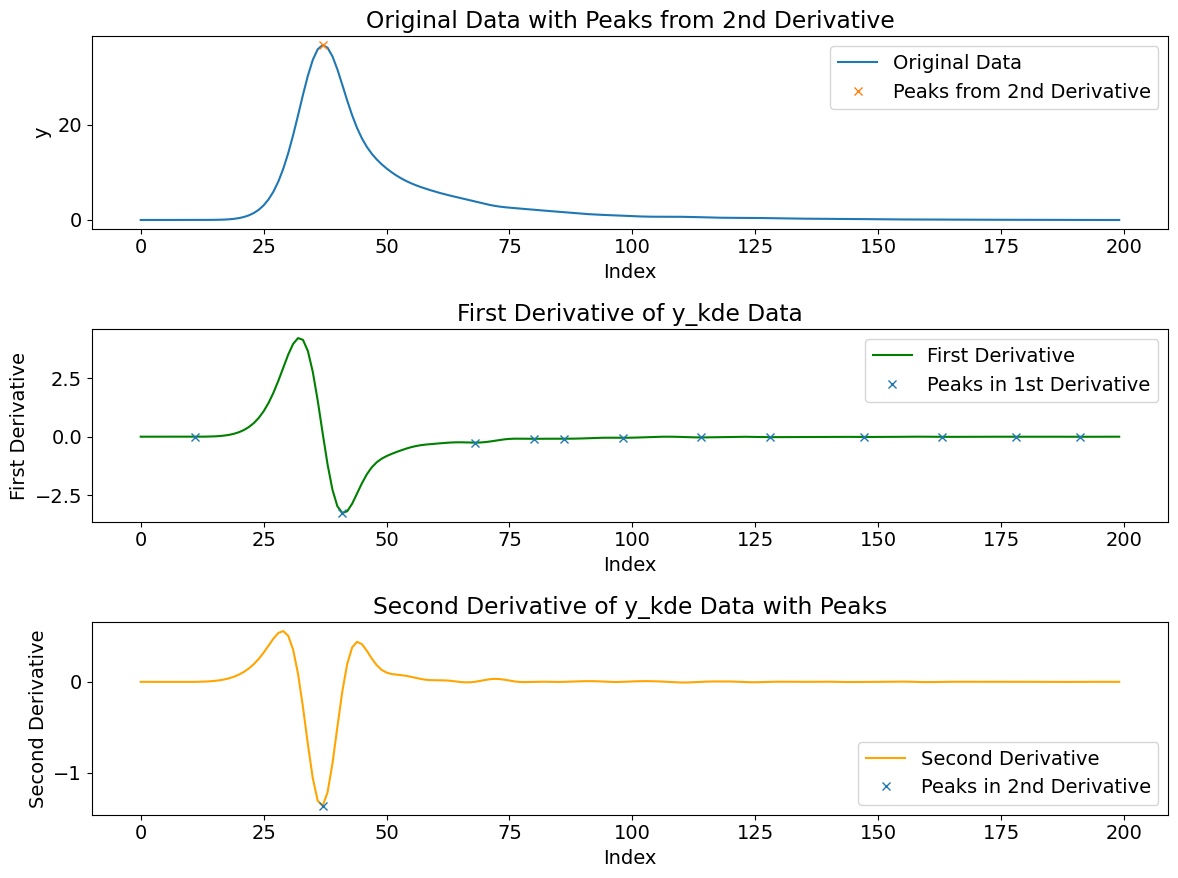

KDE-based guess for number of clusters: 1

--- Results of clustering ---
Method: GMM
Number of clusters: 1
Silhouette score: 0.4112
Davies-Bouldin score: 14.3860
Calinski-Harabasz score: 19.6172
Unique values in hardness: [5.38   5.0925 4.805  ... 9.095  8.88   8.665 ]
Unique values in modulus: [224.6   222.075 219.55  ... 186.65  174.475 162.3  ]


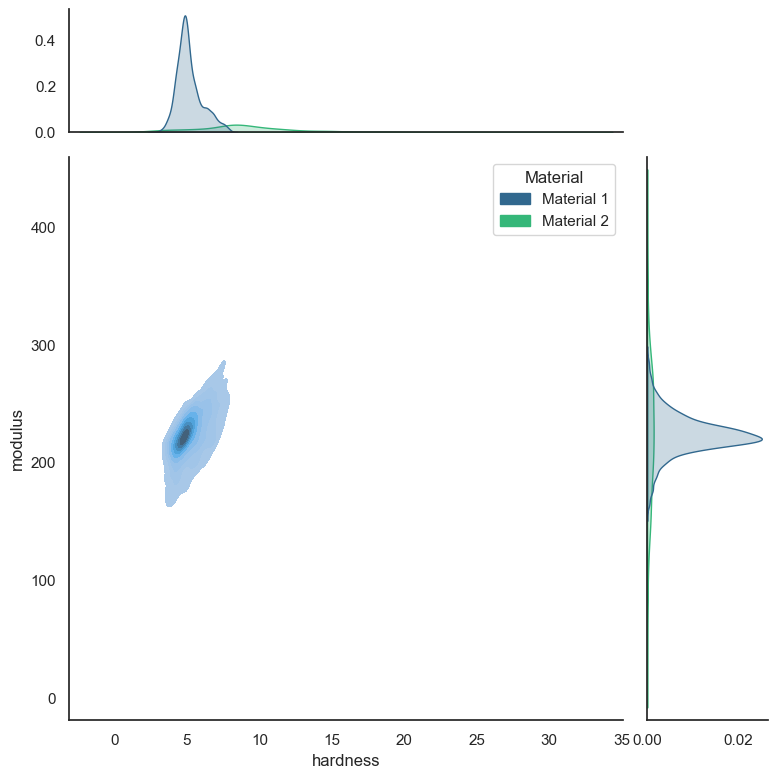

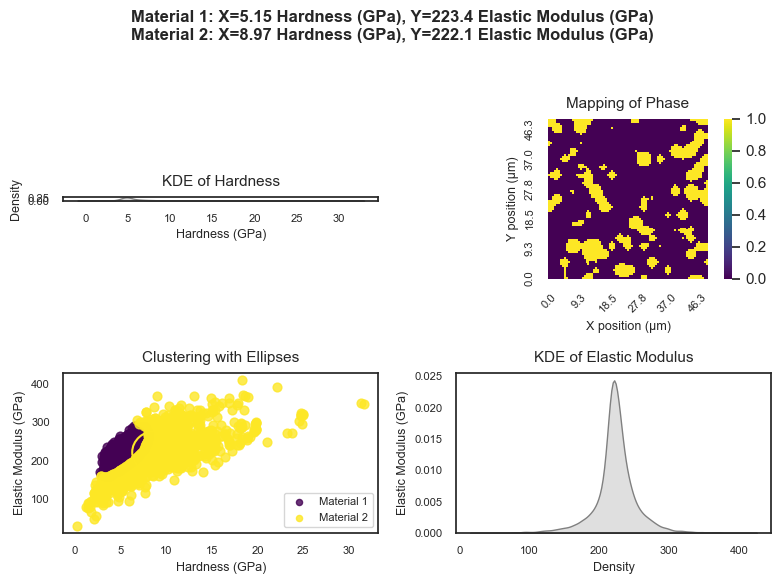

Data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\clustering_ellipses_GMM.png.csv


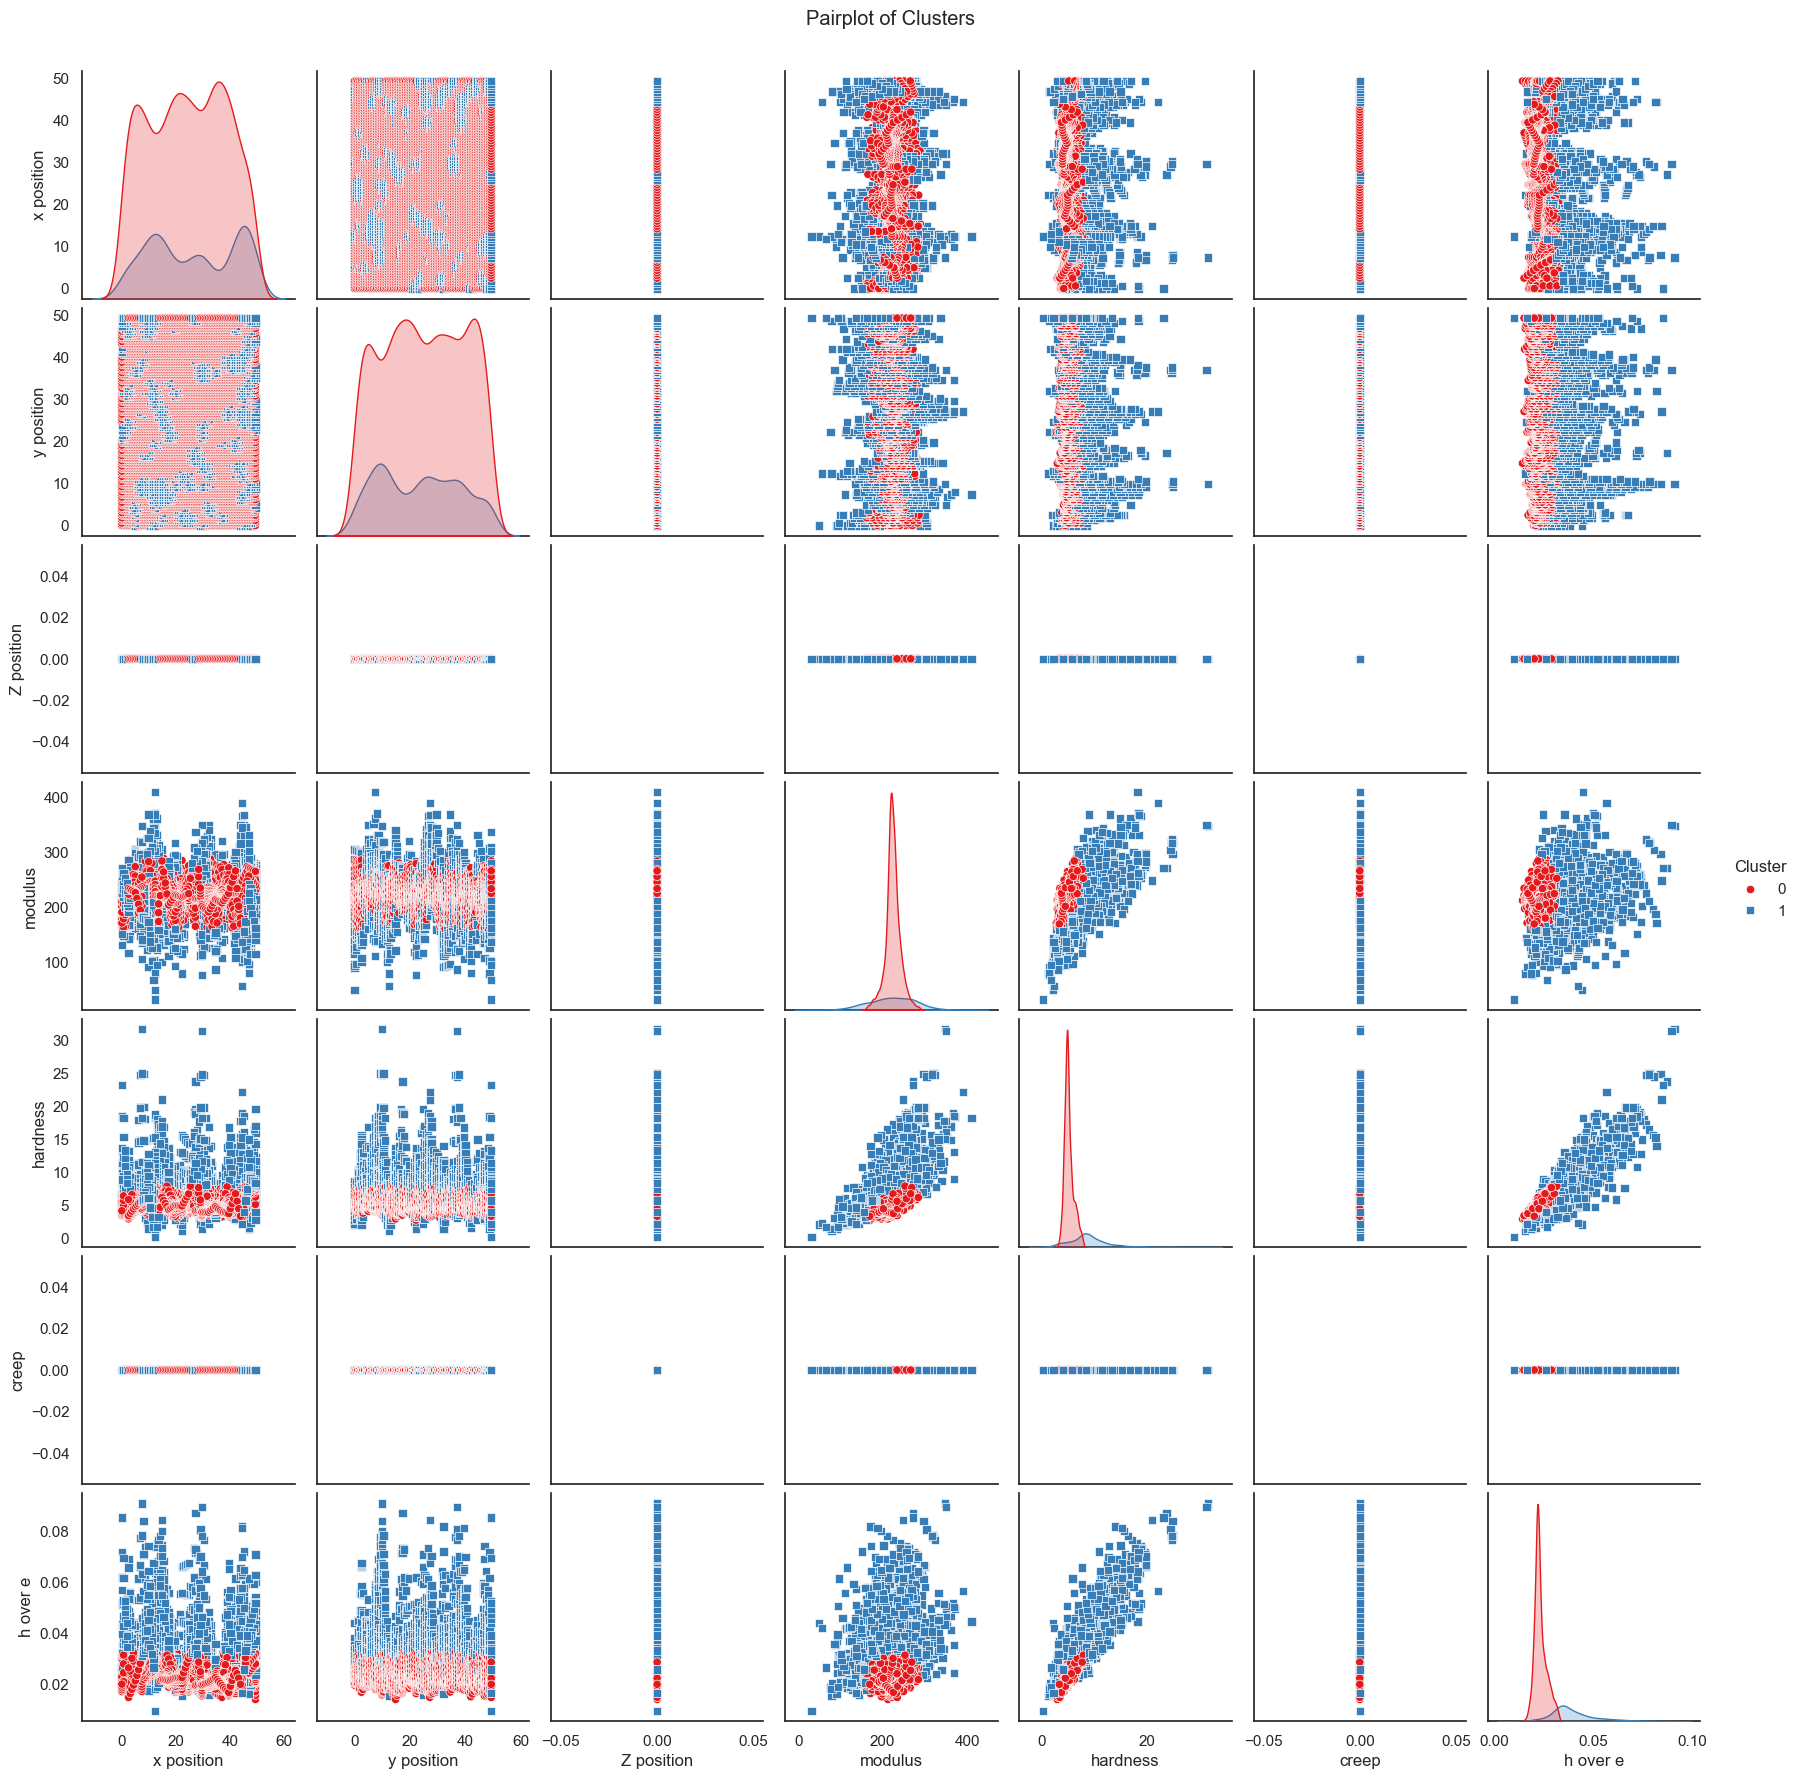

Combined hardness PDF data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\Combined_HardnessPDF.csv
Combined modulus PDF data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\Combined_ModulusPDF.csv
Cluster data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\ClusterData_GMM.csv
Cluster data successfully saved to C:\github\ICME-OoCTO\MLforMultiphaseMaterials\Data\Hybrids\Reference_Materials\Outputs_MechanicalData\Ni_SiC\Mapping_GMM.csv


c:\github\ICME-OoCTO\MLforMultiphaseMaterials\MicroMechanicalMapping\AnalyzePlot_mech.py:595: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_pdf_H_df = pd.concat(pdf_H_list, ignore_index=True)
c:\github\ICME-OoCTO\MLforMultiphaseMaterials\MicroMechanicalMapping\AnalyzePlot_mech.py:601: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_pdf_E_df = pd.concat(pdf_E_list, ignore_index=True)
c:\github\ICME-OoCTO\MLforMultiphaseMaterials\MicroMechanicalMapping\AnalyzePlot_mech.py:476: Futu

In [8]:
data.columns = [col.lower() for col in data.columns]

if not isinstance(MLmethods, list):
    MLmethods = [MLmethods]

for MLmethod in MLmethods:
# Analysis and export data :
    inputs, inputsMeta, recordName = analyze_stat_to_mi(file_path, data, json_data, MLmethod,opt_clusters_method, json_path, listAttributes, listAttributesMeta, image_paths, output_folder, dataType)
    # record = export_data_to_MI(mi_import, projectName, table_import, folderName, recordName, phaseNum, 
    #                             listAttributes, listAttributeswithMeta, inputs, inputsMeta)
    # updateLinks_MI(mi_import, record_ini[sampleName], record, table_name_ini, table_name)